# Library Import and Set-Up

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from tensorflow.keras import Sequential
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer


tf.config.run_functions_eagerly(True)
gpu_devices = tf.config.list_physical_devices('GPU')
details = tf.config.experimental.get_device_details(gpu_devices[0])
print("Available GPUs: ", details.get('device_name'))
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

2024-09-02 07:06:55.615591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 07:06:56.140602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 07:06:56.464311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 07:06:56.517595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 07:06:57.138423: I tensorflow/core/platform/cpu_feature_guar

Available GPUs:  NVIDIA GeForce RTX 3060


I0000 00:00:1725241022.410783   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725241022.901724   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725241022.901809   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725241022.903458   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725241022.909696   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

# Load Dataset

In [2]:
rawdataset = pd.read_csv("./dataset/full_dataset.csv")

In [3]:
dataset = rawdataset[:1900]
dataset = dataset.drop(["link", "source"], axis=1)

In [4]:
print("Data shape:", dataset.shape)
dataset.head()

Data shape: (1900, 5)


,Unnamed: 0,title,ingredients,directions,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu..."


# Pre-Processing the Data

In [5]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in '!"#$%&*+:;<=>?@[\]^_`{}~').lower()
    return txt

title = [clean_text(x) for x in dataset.title]
NER = [clean_text(x) for x in dataset.NER]
ingredients = [clean_text(x) for x in dataset.ingredients]
directions = [clean_text(x) for x in dataset.directions]

#### Combining ner, title, ingredients and directions data into a single string

In [6]:
finaldataset = []
for i in range(len(NER)):
    finaldataset.append(NER[i]+" | "+title[i]+" | "+ingredients[i]+" | "+directions[i])
max_length = 0
for i in finaldataset:
    max_length = max(max_length, len(i))
print("max_length:", max_length)
print()
print("Recipe at index 0:\n", finaldataset[0])

max_length: 1359

Recipe at index 0:
 brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits | no-bake nut cookies | 1 c. firmly packed brown sugar, 1/2 c. evaporated milk, 1/2 tsp. vanilla, 1/2 c. broken nuts (pecans), 2 tbsp. butter or margarine, 3 1/2 c. bite size shredded rice biscuits | in a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine., stir over medium heat until mixture bubbles all over top., boil and stir 5 minutes more. take off heat., stir in vanilla and cereal mix well., using 2 teaspoons, drop and shape into 30 clusters on wax paper., let stand until firm, about 30 minutes.


# Tokenizing the final dataset

#### Creating Tokens

In [7]:
tokenizer = Tokenizer(
    char_level=False,
    filters='',
    lower=False,
    split=' '
)
tokenizer.fit_on_texts(finaldataset)
tokenizer.fit_on_texts(["~"])

vocab_size = len(tokenizer.word_index) + 1
print("Total words:", vocab_size)

text = ["pineapple condensed milk lemons pecans graham cracker crusts"]
token_list = tokenizer.texts_to_sequences(text)
print(text)
print(token_list)

Total words: 7317
['pineapple condensed milk lemons pecans graham cracker crusts']
[[183, 236, 90, 2856, 246, 192, 205, 1595]]


In [8]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 1901,
 'word_counts': '{"brown": 540, "sugar,": 1866, "milk,": 806, "vanilla,": 419, "nuts,": 157, "butter,": 834, "bite": 20, "size": 48, "shredded": 156, "rice": 145, "biscuits": 32, "|": 5700, "no-bake": 2, "nut": 25, "cookies": 86, "1": 6726, "c.": 4732, "firmly": 24, "packed": 35, "1/2": 2660, "evaporated": 47, "tsp.": 2216, "broken": 14, "nuts": 213, "(pecans),": 1, "2": 2641, "tbsp.": 1146, "butter": 603, "or": 1129, "margarine,": 404, "3": 980, "in": 2723, "a": 1234, "heavy": 48, "2-quart": 34, "saucepan,": 42, "mix": 1103, "milk": 330, "and": 5024, "margarine.,": 36, "stir": 523, "over": 632, "medium": 324, "heat": 342, "until": 1269, "mixture": 353, "bubbles": 4, "all": 377, "top.,": 104, "boil": 120, "5": 289, "minutes": 460, "more.": 10, "take": 32, "off": 58, "heat.,": 64, "vanilla": 417, "cereal": 14, "well.,": 258, "using": 34, "teaspoons,": 1,

#### Vectorizing the dataset

In [9]:
finaldataset_token = tokenizer.texts_to_sequences(finaldataset)
print(finaldataset_token[2])
print()
print(tokenizer.sequences_to_texts([finaldataset_token[2]]))

[135, 207, 21, 30, 34, 100, 55, 14, 78, 2, 998, 132, 2, 7, 336, 41, 53, 135, 207, 1, 157, 41, 53, 21, 30, 836, 137, 4, 34, 836, 6, 8, 100, 55, 6, 8, 14, 27, 8, 78, 2, 5, 16, 2023, 3046, 64, 77, 582, 117, 3, 56, 40, 231, 17, 42, 326, 20, 15, 811, 853, 3, 43, 129, 1330, 54, 151, 214, 528, 507, 80, 290]

['frozen corn, cream cheese, butter, garlic powder, salt, pepper | creamy corn | 2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. cream cheese, cubed, 1/3 c. butter, cubed, 1/2 tsp. garlic powder, 1/2 tsp. salt, 1/4 tsp. pepper | in a slow cooker, combine all ingredients. cover and cook on low for 4 hours or until heated through and cheese is melted. stir well before serving. yields 6 servings.']


In [10]:
tokenizer.sequences_to_texts(finaldataset_token[:2])

['brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits | no-bake nut cookies | 1 c. firmly packed brown sugar, 1/2 c. evaporated milk, 1/2 tsp. vanilla, 1/2 c. broken nuts (pecans), 2 tbsp. butter or margarine, 3 1/2 c. bite size shredded rice biscuits | in a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine., stir over medium heat until mixture bubbles all over top., boil and stir 5 minutes more. take off heat., stir in vanilla and cereal mix well., using 2 teaspoons, drop and shape into 30 clusters on wax paper., let stand until firm, about 30 minutes.',
 "beef, chicken breasts, cream of mushroom soup, sour cream | jewell ball's chicken | 1 small jar chipped beef, cut up, 4 boned chicken breasts, 1 can cream of mushroom soup, 1 carton sour cream | place chipped beef on bottom of baking dish., place chicken on top of beef., mix soup and cream together pour over chicken. bake, uncovered, at 275u00b0 for 3 hours."]

# Creating N-gram sequences

In [11]:
input_sequences = []
for line in finaldataset:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [12]:
for i in input_sequences[0:10]:
    print(i, tokenizer.sequences_to_texts([i]))

[51, 10] ['brown sugar,']
[51, 10, 36] ['brown sugar, milk,']
[51, 10, 36, 65] ['brown sugar, milk, vanilla,']
[51, 10, 36, 65, 179] ['brown sugar, milk, vanilla, nuts,']
[51, 10, 36, 65, 179, 34] ['brown sugar, milk, vanilla, nuts, butter,']
[51, 10, 36, 65, 179, 34, 927] ['brown sugar, milk, vanilla, nuts, butter, bite']
[51, 10, 36, 65, 179, 34, 927, 487] ['brown sugar, milk, vanilla, nuts, butter, bite size']
[51, 10, 36, 65, 179, 34, 927, 487, 181] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded']
[51, 10, 36, 65, 179, 34, 927, 487, 181, 199] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded rice']
[51, 10, 36, 65, 179, 34, 927, 487, 181, 199, 677] ['brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits']


In [13]:
max_seq_len = max(len(x) for x in input_sequences)
print("Input Sequences Length:", len(input_sequences))
print("Max sequences Length:", max_seq_len)

Input Sequences Length: 170367
Max sequences Length: 231


# Padding the sequences with 0

In [14]:
print("Before padding")
print(input_sequences[3], len(input_sequences[3]))

Before padding
[51, 10, 36, 65, 179] 5


In [15]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding = 'pre'))

In [16]:
print("After padding")
print(input_sequences[3], len(input_sequences[3]))

After padding
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  51  10  36  65 179] 231


# Spliting Predictor and Predictand

In [17]:
features, labels = input_sequences[:, :-1], input_sequences[:, -1]

In [18]:
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)
print()
print("Data at index 3")
print("Features:", tokenizer.sequences_to_texts([features[3]]))
print("Labels:", tokenizer.sequences_to_texts([[labels[3]]]))

Features Shape: (170367, 230)
Labels Shape: (170367,)

Data at index 3
Features: ['brown sugar, milk, vanilla,']
Labels: ['nuts,']


In [19]:
print("dataset size in disk")
print("Features:", features.nbytes/1e+9)
print("Labels:", labels.nbytes/1e+9)

dataset size in disk
Features: 0.15673764
Labels: 0.000681468


In [20]:
labels = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

In [21]:
print("dataset size in disk")
print("Labels:", labels.nbytes/1e+9)
print("Labels Shape:", labels.shape)

dataset size in disk
Labels: 9.972602712
Labels Shape: (170367, 7317)


#### Reducing dataset size

In [22]:
n = 10
slice_size = int(len(features)/n)
print("Slice size:", slice_size)

Slice size: 17036


In [23]:
features = features[:slice_size, :]
labels = labels[:slice_size]

In [24]:
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)
print("dataset size in disk")
print("Features:", features.nbytes/1e+9)
print("Labels:", labels.nbytes/1e+9)

Features Shape: (17036, 230)
Labels Shape: (17036, 7317)
dataset size in disk
Features: 0.01567312
Labels: 0.997219296


# Model Training

In [25]:
def generator_model():
    model = Sequential([
    Embedding(vocab_size, 256, input_length=max_seq_len),
    GRU(126),
    Dense(vocab_size, activation='softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
              metrics = ['accuracy'])
    return model

In [26]:
model = generator_model()

/home/rahul/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1725241047.918202   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725241047.921420   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725241047.921529   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725241047.931251   13109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-02 07:07:27.934275: I tensor

In [27]:
history = model.fit(features, labels, epochs = 25, batch_size=64)

/home/rahul/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-09-02 07:08:15.664577: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


267/267 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.0412 - loss: 7.2925
Epoch 2/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.1408 - loss: 5.5213
Epoch 3/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.2189 - loss: 4.5880
Epoch 4/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.2695 - loss: 3.9736
Epoch 5/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.3238 - loss: 3.3868
Epoch 6/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.3842 - loss: 2.8671
Epoch 7/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.4712 - loss: 2.3841
Epoch 8/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.5352 - loss: 1.9976
Epoch 9/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.6116 - loss: 1.6628
Epoch 10/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.6643 - loss: 1.4197
Epoch 11/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.7109 - loss: 1.2307
Epoch 12/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 

#### Model Summary

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 230, 256)         │     1,873,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, 126)              │       145,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 7317)             │       929,259 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,842,691 (33.73 MB)

 Trainable params: 2,947,563 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,895,128 (22.49 MB)

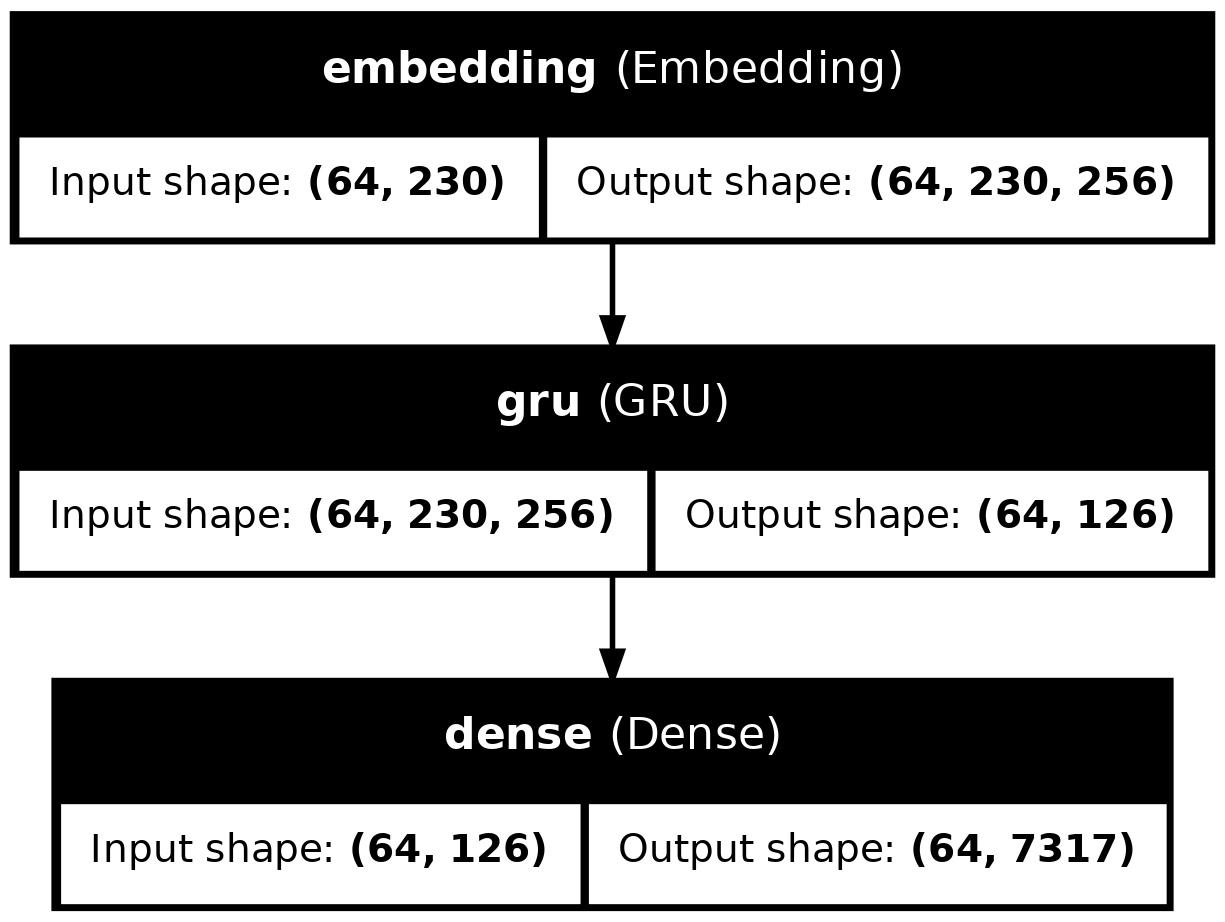

In [29]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [30]:
print("Model Accuracy:", max(history.history['accuracy']))
print("Loss:", min(history.history['loss']))

Model Accuracy: 0.9590866565704346
Loss: 0.2154608517885208


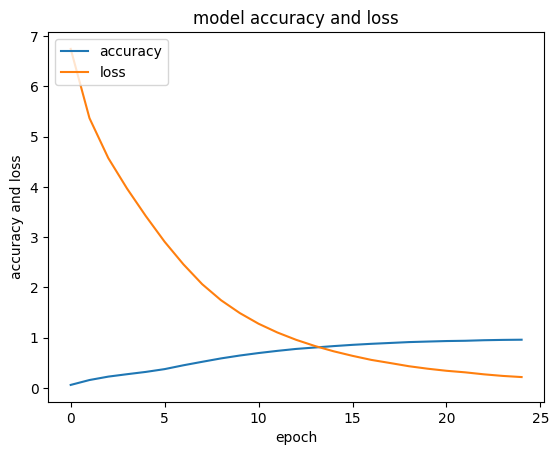

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy and loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

# Model Testing

In [42]:
def generate_text(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding = "pre")
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=-1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text

In [43]:
ing = "hearts, mayonnaise, parmesan cheese"
print("Ingredients:", ing)
print("\nPredicted Recipe:")
print(generate_text(ing, 100))

Ingredients: hearts, mayonnaise, parmesan cheese

Predicted Recipe:
hearts, mayonnaise, parmesan cheese | artichoke dip | 2 cans or jars artichoke hearts, 1 c. mayonnaise, 1 c. parmesan cheese | drain artichokes and chop., mix with mayonnaise and parmesan cheese., after well mixed, bake, uncovered, for 20 to 30 minutes at 350u00b0., serve with crackers. makes 8 servings. cut in half and clean it. put peppers in boiling water for 3 minutes- drain- spoon the meat mixture into the green pepper. put pepper in an ungreased pan. cover, and bake at 350 degrees for 15 to 20 minutes or until peppers are crispy and filling is heated through. top with remaining cheese,


In [44]:
print("Actual Data:")
print(finaldataset[37])
print("\nPredicted Data:")
generate_text("salad supreme, italian dressing", 100)

Actual Data:
salad supreme, italian dressing | summer spaghetti | 1 lb. very thin spaghetti, 1/2 bottle mccormick salad supreme (seasoning), 1 bottle zesty italian dressing | prepare spaghetti per package., drain., melt a little butter through it., marinate overnight in salad supreme and zesty italian dressing., just before serving, add cucumbers, tomatoes, green peppers, mushrooms, olives or whatever your taste may want.

Predicted Data:


'salad supreme, italian dressing | summer spaghetti | 1 lb. very thin spaghetti, 1/2 bottle mccormick salad supreme (seasoning), 1 bottle zesty italian dressing | prepare spaghetti per package., drain., melt a little butter through it., marinate overnight in salad supreme and zesty italian dressing., just before serving, add cucumbers, tomatoes, green peppers, mushrooms, olives or whatever your taste may want. put peppers in large glass baking dish., spread out evenly., sprinkle cheese and sprinkle over sugar., sprinkle with sugar., bake on bottom shelf at 400u00b0 for 45 minutes. cook in preheated 325u00b0 oven for 1 hour or until knife inserted in center comes'

# Saving the model

In [45]:
model.save("Culinary-Companion-V0.1.keras")